In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [2]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict()]
    att = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        if m == 'BirdFluxGraphLSTM':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att

In [48]:
def plot_fluxes(voronoi, G, fluxes, results, trial=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f for f in fluxes[0].values()], dim=-1)
    mask = np.concatenate([results['BirdFluxGraphLSTM'].query(f'seqID == {i}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results['BirdFluxGraphLSTM'].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
    cmap = cm.get_cmap('YlOrBr')
    edge_widths = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths /= 0.25 * edge_widths.max()
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    fig, ax = plt.subplots(figsize=(10,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100})
    ax.set(title='averaged inferred fluxes between radars');
    return G_new

In [4]:
def plot_sensitivity(results, sigmas, m):
    rmse = []
    for r in results:
        rmse.append(r[m].groupby('trial').error.aggregate(np.nanmean).apply(np.sqrt).values)
    rmse = np.stack(rmse)
    fig, ax = plt.subplots()
    ax.plot(sigmas, rmse.mean(1), '-o', label='perturbed BirdFluxGraphLSTM')
    ax.fill_between(sigmas, rmse.mean(1) - rmse.std(1), rmse.mean(1) + rmse.std(1), alpha=0.2)
    ref_rmse = results[0]['LocalLSTM'].groupby('trial').error.aggregate(np.nanmean).apply(np.sqrt).values
    ax.plot(sigmas, [ref_rmse.mean()] * len(sigmas), label='LocalLSTM')
    ax.fill_between(sigmas, [ref_rmse.mean() - ref_rmse.std()] * len(sigmas), [ref_rmse.mean() + ref_rmse.std()] * len(sigmas), alpha=0.2)
    ax.set(xlabel='perturbation std [birds/km2]', ylabel='RMSE')
    ax.legend()
    return fig

In [5]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values

In [78]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary, bird_scales_fixed_boundary, fluxes_fixed_boundary, _ = load_results(models, experiments, base_dir)

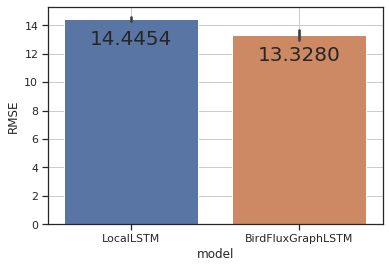

In [79]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary, night_only=True)

In [80]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fixed_boundary_performance.png', bbox_inches='tight', dpi=300)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.2)$

In [76]:
print(f'std of 0.2 means std of {0.2 * 293} birds/km2')

std of 0.2 means std of 58.6 birds/km2


In [99]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std02, _, fluxes_fixed_boundary_std02, _ = load_results(models, experiments, base_dir)

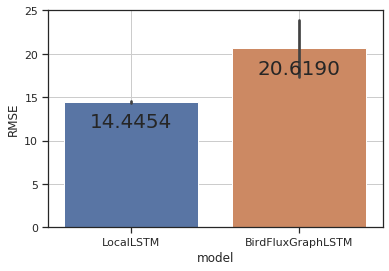

In [100]:
fig = utils.plot_average_errors(results_fixed_boundary_std02, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.15)$

In [109]:
print(f'std of 0.15 means std of {0.15 * 293} birds/km2')

std of 0.15 means std of 43.949999999999996 birds/km2


In [107]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std015, _, fluxes_fixed_boundary_std015, _ = load_results(models, experiments, base_dir)

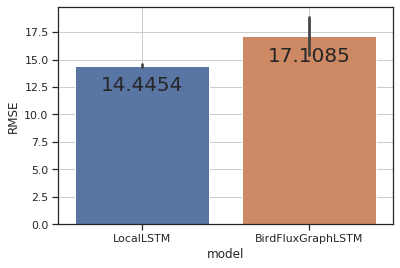

In [108]:
fig = utils.plot_average_errors(results_fixed_boundary_std015, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.1)$

In [78]:
print(f'std of 0.1 means std of {0.1 * 293} birds/km2')

std of 0.1 means std of 29.3 birds/km2


In [110]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std01, _, fluxes_fixed_boundary_std01, _ = load_results(models, experiments, base_dir)

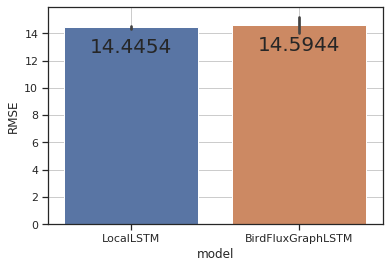

In [111]:
fig = utils.plot_average_errors(results_fixed_boundary_std01, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.05)$

In [79]:
print(f'std of 0.05 means std of {0.05 * 293} birds/km2')

std of 0.05 means std of 14.65 birds/km2


In [105]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std005, _, fluxes_fixed_boundary_std005, _ = load_results(models, experiments, base_dir)

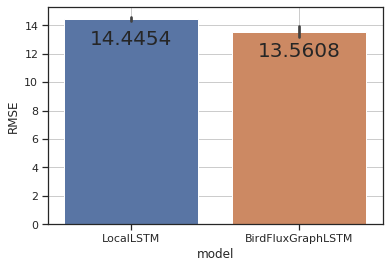

In [106]:
fig = utils.plot_average_errors(results_fixed_boundary_std005, boundary=boundary, night_only=True)

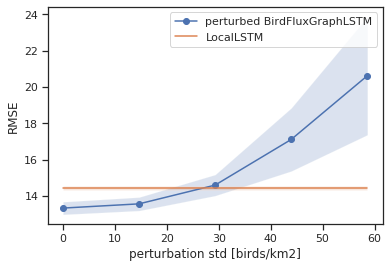

In [134]:
bird_scale = 293
fig = plot_sensitivity([results_fixed_boundary,
                 results_fixed_boundary_std005,
                 results_fixed_boundary_std01,
                 results_fixed_boundary_std015,
                 results_fixed_boundary_std02],
                 np.array([0, 0.05, 0.1, 0.15, 0.2]) * bird_scale, 'BirdFluxGraphLSTM')
fig.savefig('/home/fiona/birdMigration/data/plots/BirdFluxGraphLSTM/sensitivity_to_boundary.png', bbox_inches='tight', dpi=300)

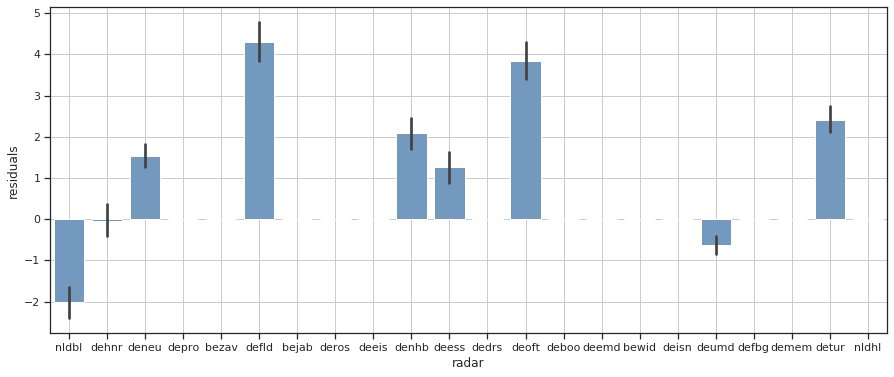

In [33]:
fig = utils.plot_errors_per_radar(results_fixed_boundary, 'BirdFluxGraphLSTM')

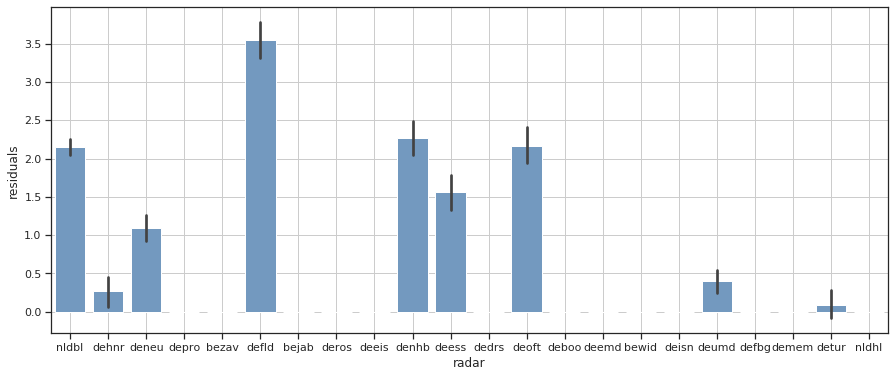

In [26]:
fig = utils.plot_errors_per_radar(results_boundary_fluxmlp, 'BirdFluxGraphLSTM')

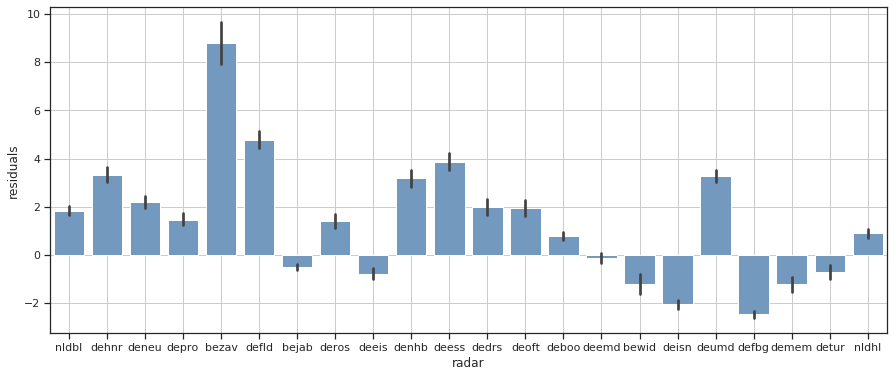

In [27]:
fig = utils.plot_errors_per_radar(results_boundary_lstm, 'BirdFluxGraphLSTM')

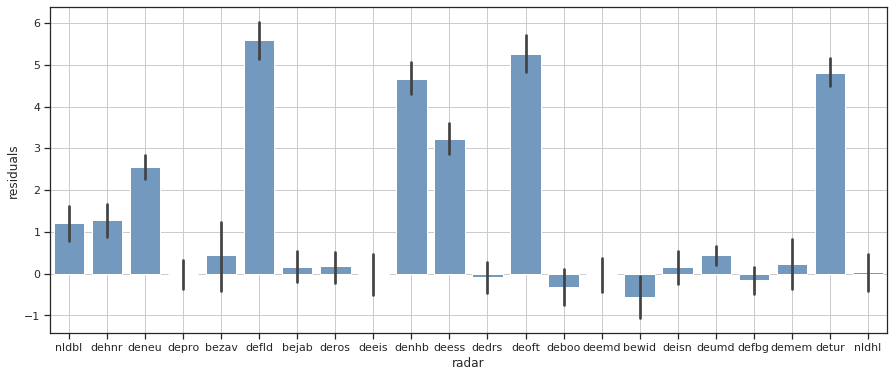

In [39]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std005, 'BirdFluxGraphLSTM')

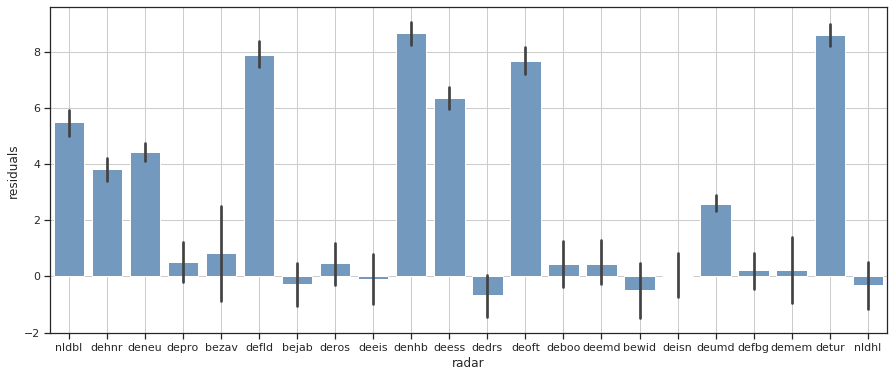

In [28]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std01, 'BirdFluxGraphLSTM')

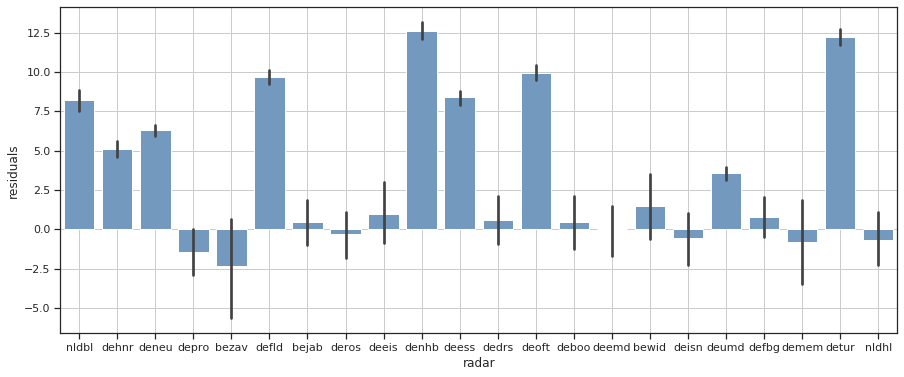

In [36]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std02, 'BirdFluxGraphLSTM')

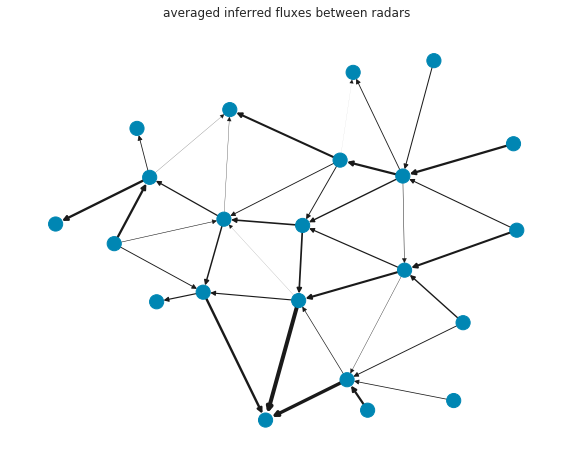

In [10]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

plot_fluxes(voronoi, G, fluxes_fixed_boundary, results_fixed_boundary, trial=0)

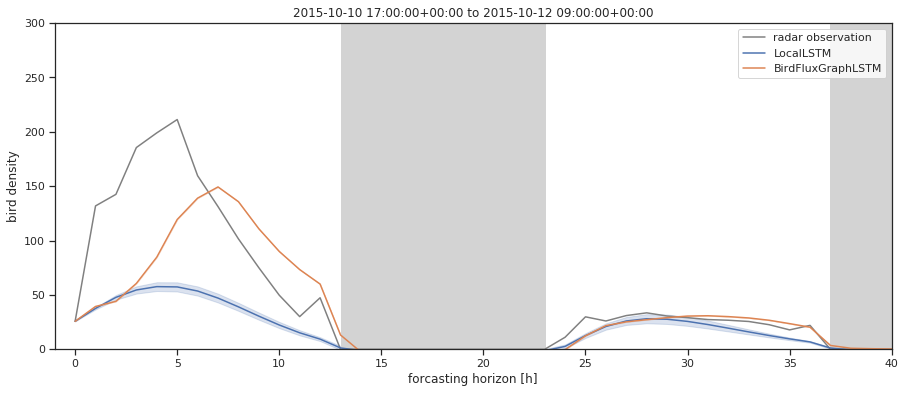

In [44]:
fig = utils.plot_example_prediction(results_fixed_boundary, 'denhb', 44, max=300)

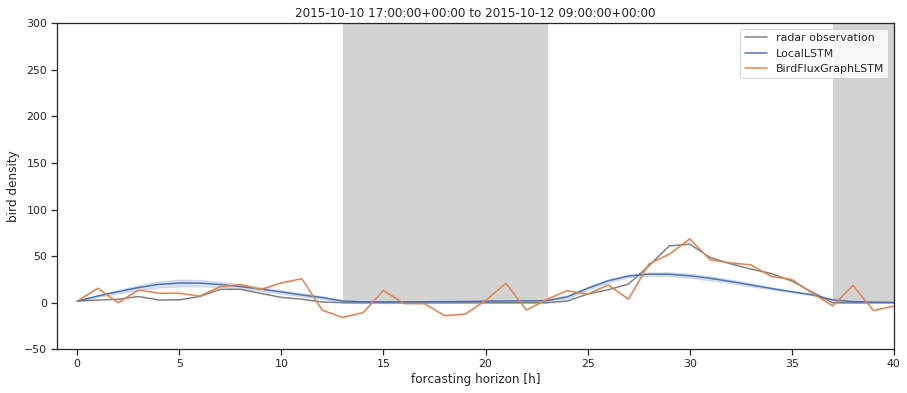

In [49]:
fig = utils.plot_example_prediction(results_fixed_boundary_std005, 'defbg', 44, max=300, min=-50)

In [7]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_lstm_without_dummy_radars']
results_boundary_lstm, bird_scales_boundary_lstm, fluxes_boundary_lstm, _ = load_results(models, experiments, base_dir)

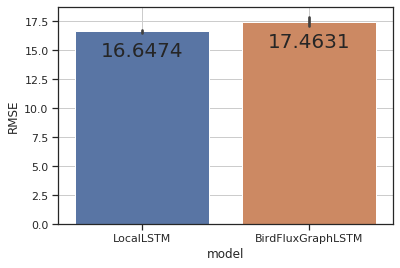

In [14]:
fig = utils.plot_average_errors(results_boundary_lstm, boundary=[], night_only=True)

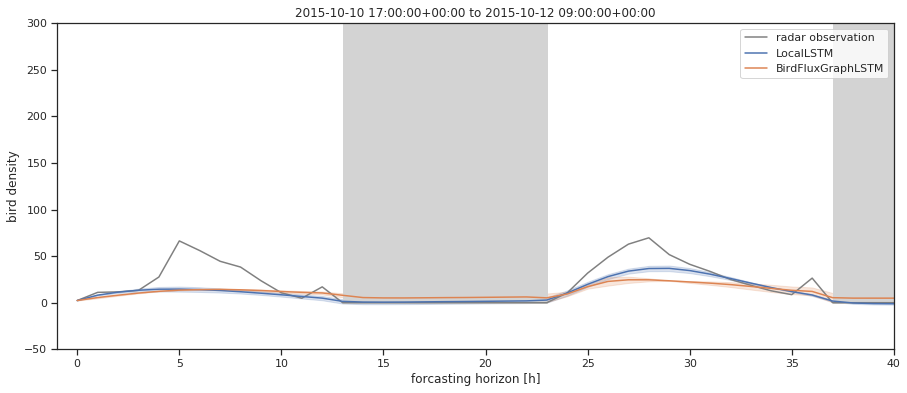

In [20]:
fig = utils.plot_example_prediction(results_boundary_lstm, 'detur', 44, max=300, min=-50)

In [6]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_fluxmlp_without_dummy_radars_constrained_fluxes01_dayofyear']
results_boundary_fluxmlp, bird_scales_boundary_fluxmlp, fluxes_boundary_fluxmlp, _ = load_results(models, experiments, base_dir)

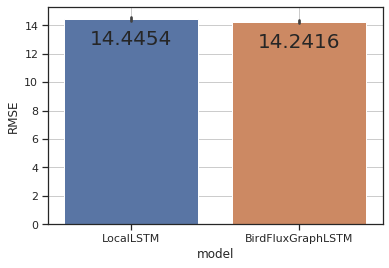

In [96]:
fig = utils.plot_average_errors(results_boundary_fluxmlp, boundary=boundary, night_only=True)

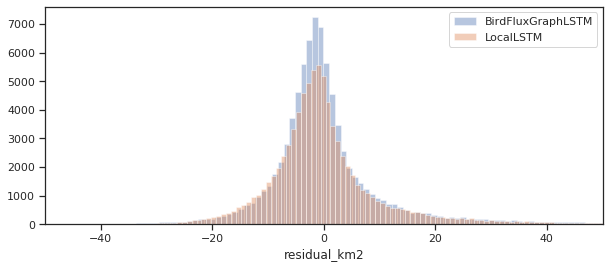

In [158]:
fig, ax = plt.subplots(figsize=(10,4))
df = results_boundary_fluxmlp['BirdFluxGraphLSTM'].query(f'night == True & missing == False & radar not in {list(boundary)} & horizon > 0')
sb.distplot(df.residual_km2, kde=False, ax=ax, bins=300, label='BirdFluxGraphLSTM')
df = results_boundary_fluxmlp['LocalLSTM'].query(f'night == True & missing == False & horizon > 0 & radar not in {list(boundary)}')
sb.distplot(df['gt_km2'] - df['prediction_km2'], kde=False, ax=ax, bins=300, label='LocalLSTM')
ax.set(xlim=(-50, 50))
ax.legend()

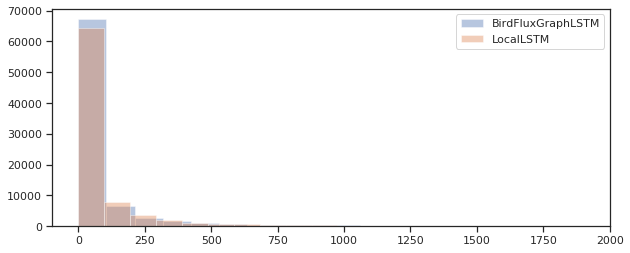

In [164]:
fig, ax = plt.subplots(figsize=(10,4))
df = results_boundary_fluxmlp['BirdFluxGraphLSTM'].query(f'night == True & missing == False & radar not in {list(boundary)} & horizon > 0')
sb.distplot(np.power(df.residual_km2.to_numpy(), 2), kde=False, ax=ax, bins=500, label='BirdFluxGraphLSTM')
df = results_boundary_fluxmlp['LocalLSTM'].query(f'night == True & missing == False & horizon > 0 & radar not in {list(boundary)}')
sb.distplot(np.power((df['gt_km2'] - df['prediction_km2']).to_numpy(), 2), kde=False, ax=ax, bins=500, label='LocalLSTM')
ax.set(xlim=(-100, 2000))
ax.legend()

In [117]:
trial = 0
all_radar_fluxes = []
all_model_fluxes = []
for nidx in range(50):
    diff = fluxes_boundary_fluxmlp[1][trial][nidx] - fluxes_boundary_fluxmlp[0][trial][nidx]
    constraints = (diff[~torch.isnan(diff)]**2).sum() / 100
    radar = fluxes_boundary_fluxmlp[1][trial][nidx]
    all_radar_fluxes.append(radar)
    avg_radar = radar[~torch.isnan(radar)].max()
    model = fluxes_boundary_fluxmlp[0][trial][nidx]
    all_model_fluxes.append(model)
    avg_model = model[~torch.isnan(model)].max()
    #print(avg_radar, avg_model, constraints)
all_radar_fluxes = torch.cat(all_radar_fluxes).view(-1, 1)
all_radar_fluxes = all_radar_fluxes[all_radar_fluxes != 0]
all_model_fluxes = torch.cat(all_model_fluxes).view(-1, 1)
all_model_fluxes = all_model_fluxes[all_model_fluxes != 0].detach().numpy()

[(0, 100), (-0.05, 0.05)]

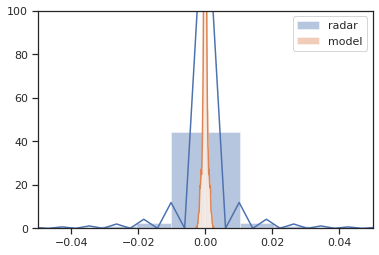

In [125]:
fig, ax = plt.subplots()
sb.distplot(all_radar_fluxes, ax=ax, label='radar')
sb.distplot(all_model_fluxes, ax=ax, label='model')
ax.legend()
ax.set(xlim=(-0.05, 0.05), ylim=(0, 100))

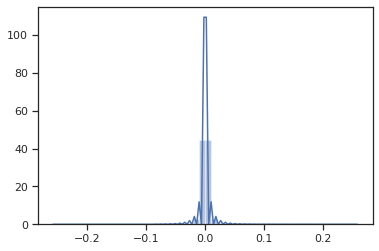

In [124]:
sb.distplot(all_radar_fluxes)

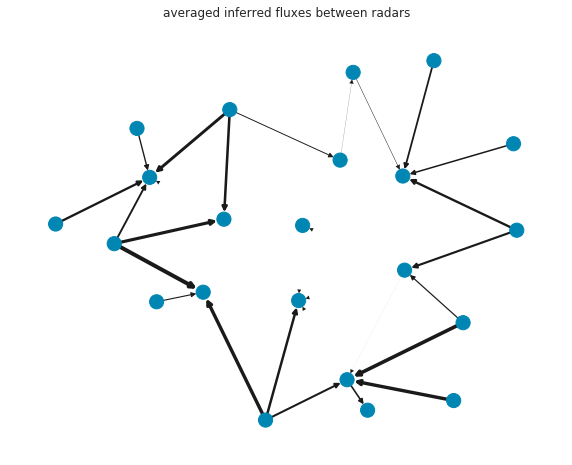

In [104]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_boundary_fluxmlp[0], results_boundary_fluxmlp, trial=0)

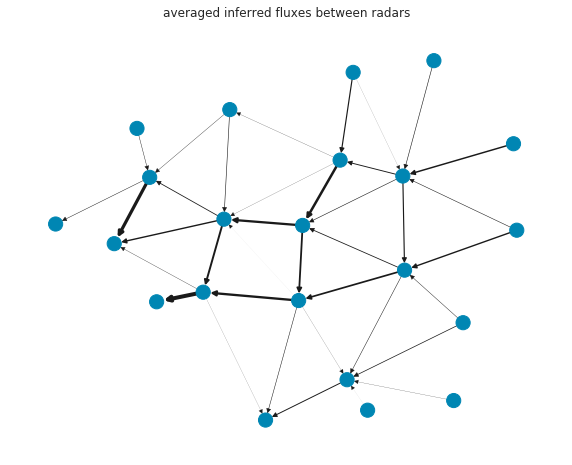

In [91]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_boundary_fluxmlp[1], results_boundary_fluxmlp, trial=0)

In [100]:
for i, j, data in G_new.edges(data=True):
    print(G_new.nodes(data=True)[i]['radar'], G_new.nodes(data=True)[j]['radar'], data['flux'])

bezav nldbl 0.00010957938
bezav denhb 0.00023279512
bezav deess 0.00018247857
bejab nldbl 0.00013410299
deess nldbl 1.6014144e-10
deemd nldbl 0.0001708196
deemd dehnr 5.54868e-05
deemd deess 0.00014887616
nldhl nldbl 7.93063e-05
dehnr deboo 8.992134e-06
defld deoft 6.373629e-09
deboo deumd 2.7404076e-05
deneu defld 2.338065e-09
deneu deoft 4.640899e-08
deneu detur 1.4023266e-06
deeis deneu 6.9986454e-05
deeis detur 0.00021025748
dedrs deneu 0.0001248841
dedrs deumd 0.00013647869
detur deoft 1.2715231e-08
detur demem 9.3910916e-05
depro deumd 8.8123496e-05
deros deumd 0.000104112885
bewid denhb 6.421182e-05
deisn detur 0.00019771815
defbg denhb 0.00019738739
defbg deoft 0.00014330154
defbg detur 0.00011791852


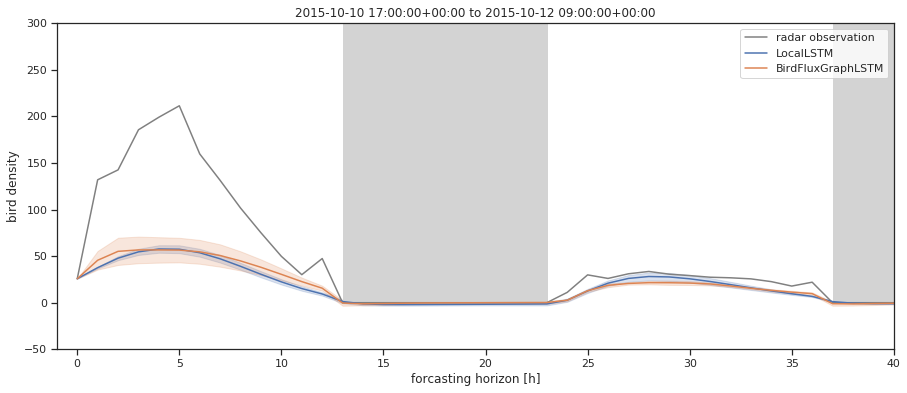

In [25]:
fig = utils.plot_example_prediction(results_boundary_fluxmlp, 'denhb', 44, max=300, min=-50)

In [63]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_without_dummy_radars_sigmoid']
results_fixed, bird_scales_fixed, fluxes_fixed, _ = load_results(models, experiments, base_dir)

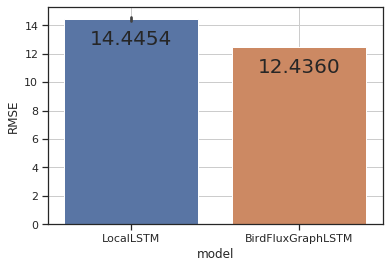

In [64]:
fig = utils.plot_average_errors(results_fixed, boundary=boundary, night_only=True)

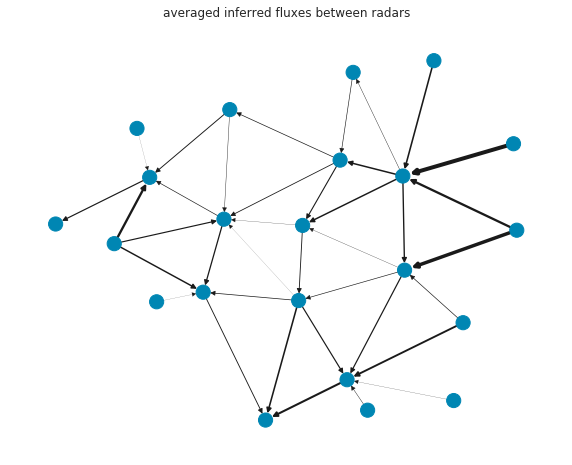

In [65]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_fixed[0], results_fixed, trial=0)

In [87]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes02_sigmoid']
results_constrained_boundary_fluxmlp, bird_scales_constrained_boundary_fluxmlp, fluxes_constrained_boundary_fluxmlp, _ = load_results(models, experiments, base_dir)

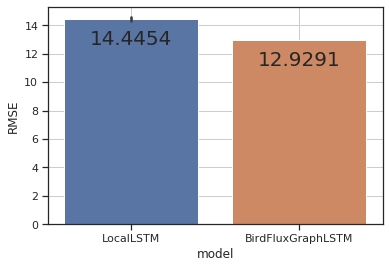

In [88]:
fig = utils.plot_average_errors(results_constrained_boundary_fluxmlp, boundary=boundary, night_only=True)

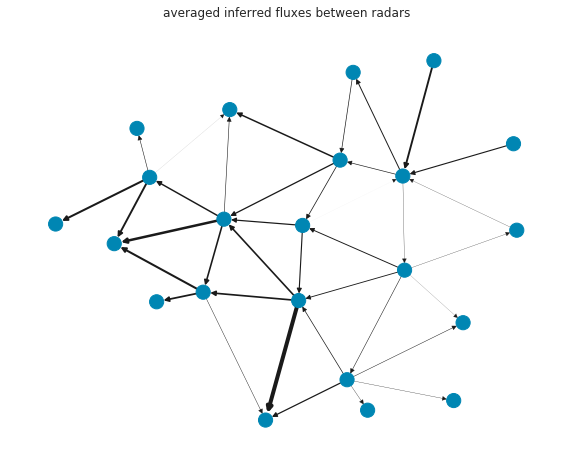

In [72]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_constrained_boundary_fluxmlp[0], results_constrained_boundary_fluxmlp, trial=0)

In [57]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes01_dayofyear_encoder_sigmoid']
results_encoder2, bird_scales_encoder2, fluxes_encoder2, _ = load_results(models, experiments, base_dir)

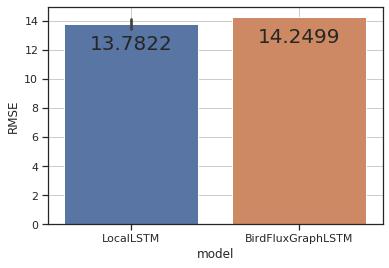

In [58]:
fig = utils.plot_average_errors(results_encoder2, boundary=boundary, night_only=True)

In [69]:
a = torch.zeros(22, 128)
b = torch.zeros(22, 1)
a * b

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [82]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              #'fixed_boundary_without_dummy_radars_encoder_new']
               'boundary_fluxmlp_without_dummy_radars_encoder']
results_encoder, bird_scales_encoder, fluxes_encoder, _ = load_results(models, experiments, base_dir)

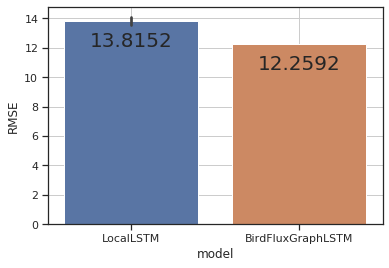

In [67]:
fig = utils.plot_average_errors(results_encoder, boundary=boundary, night_only=True)

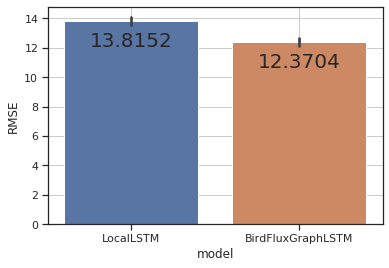

In [83]:
fig = utils.plot_average_errors(results_encoder, boundary=boundary, night_only=True)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


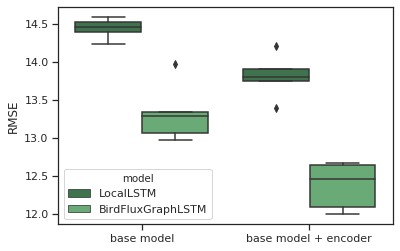

In [85]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
results = {'base model': results_fixed_boundary, 
           'base model + encoder': results_encoder}

df_compare = dict(RMSE = [], model=[], experiment=[])
for label, r in results.items():
    for m in models:
        df = r[m].query(f'missing == False & radar not in {list(boundary)} & night == True')
        df['error'] = (df['gt_km2'] - df['prediction_km2']) ** 2
        df = df.groupby('trial')
        rmse = df.error.aggregate(np.nanmean).apply(np.sqrt)
        df_compare['RMSE'].extend(rmse.values)
        df_compare['model'].extend([m] * len(rmse))
        df_compare['experiment'].extend([label] * len(rmse))
df_compare = pd.DataFrame(df_compare) 
fig, ax = plt.subplots()
sb.boxplot(x='experiment', y='RMSE', hue='model', data=df_compare, ax=ax, palette="Greens_d")
ax.set(xlabel="");

In [86]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/encoder_fixed_boundary_performance.png', bbox_inches='tight', dpi=300)

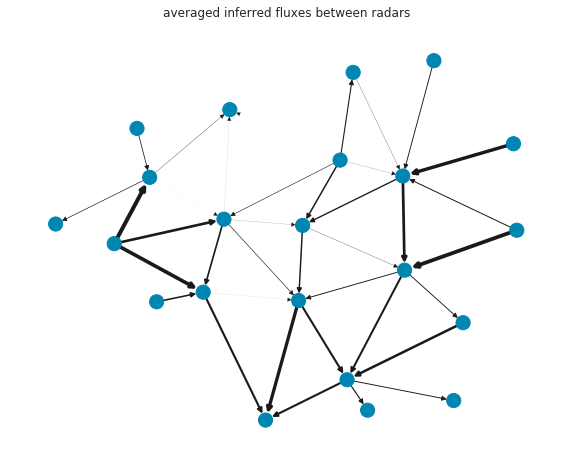

In [94]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder[0], results_encoder, trial=0)

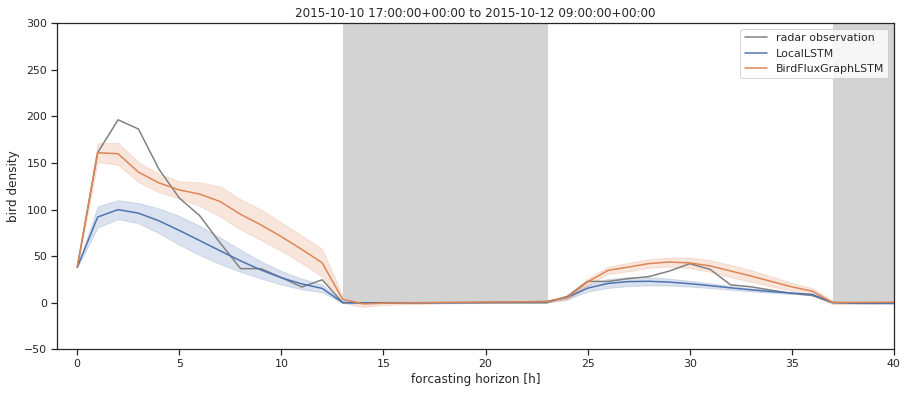

In [17]:
fig = utils.plot_example_prediction(results_encoder, 'deess', 44, max=300, min=-50)